In [288]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

In [289]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
fmri = sns.load_dataset("fmri")
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
5,s9,18,stim,parietal,-0.103513
6,s8,18,stim,parietal,-0.064408
7,s7,18,stim,parietal,-0.060526
8,s6,18,stim,parietal,-0.007029
9,s5,18,stim,parietal,-0.040557


/Users/ghost/src/virtual_env/jupyther3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


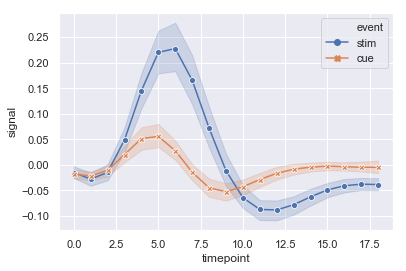

In [290]:

#ax = sns.lineplot(x=np.array(tuple(fmri.timepoint)), 
ax = sns.lineplot(x="timepoint", 
                  y="signal", 
                  hue="event",
                  style="event",
                  markers=True,
                  dashes=False,
                  data=fmri)

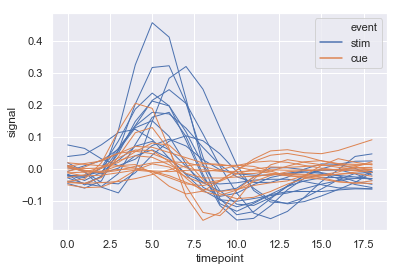

In [291]:
ax = sns.lineplot(x="timepoint", 
                  y="signal", 
                  hue="event",
                  units="subject", 
                  estimator=None, 
                  lw=1,
                  data=fmri.query("region == 'frontal'"))

In [292]:
db = pd.read_csv("my-data/output.csv")
db

,run,database,record,workload,latency,record_nbr
0,r1,redis,1000,workload a,1036,"1,000"
1,r1,redis,10000,workload a,2136,"10,000"
2,r1,redis,100000,workload a,5126,"100,000"
3,r1,redis,1000000,workload a,6136,"1,000,000"
4,m1,mongodb,1000,workload a,2536,"1,000"
5,m1,mongodb,10000,workload a,3636,"10,000"
6,m1,mongodb,100000,workload a,4196,"100,000"
7,m1,mongodb,1000000,workload a,5636,"1,000,000"
8,cb1,couchbase,1000,workload a,1826,"1,000"
9,cb1,couchbase,10000,workload a,3536,"10,000"


In [297]:
def renderGraph(db, workload):
    new_db = setCriteria(db, workload)
    graph = setLinePlot(new_db,workload)
    exportGraph(graph, workload)

def setCriteria(db, workload):
    return db[db.workload == workload ]

def setLinePlot(db, workload):
    dbgraph = sns.lineplot(x=db.record_nbr, 
                          y=db.latency, 
                          hue=db.database,
                          style=db.database,
                          sort=False,
                          legend='full',
                          markers=True,
                          dashes=True)
    handles, labels = dbgraph.get_legend_handles_labels()
    dbgraph.legend(handles=handles[1:], labels=labels[1:])
    dbgraph.set(xlabel='Number of Records', ylabel="Time (ms)")
    dbgraph.set_title(workload.upper())
    dbgraph
    
    return dbgraph

def setFileName(workload):
    name = workload.replace(" ", "")
    filename = "".join((name,'.png'))
    return filename

def exportGraph(graph, workload):
    name = setFileName(workload)
    fig = graph.get_figure()
    fig.savefig(name)
    fig.show
    return


workload b


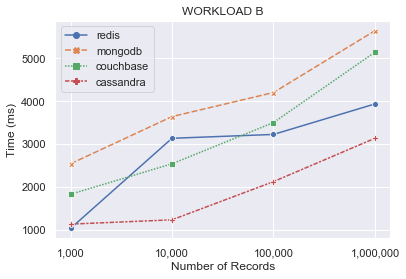

In [298]:
workload = 'workload b'
renderGraph(db, workload)

workload a


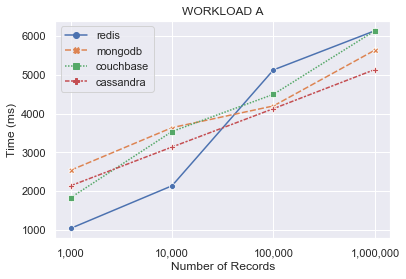

In [299]:
workload = 'workload a'
renderGraph(db, workload)